In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Preprocessing Data

In [2]:
data_root = 'data/'
seed = 27

df = TabularDataset(data_root + 'train_dataset.csv')
df = df.reset_index(drop=True)
df

,ID,pms_i_ymd,Area,Province,Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,Mortgage_balance,Credit Card_balance,Automobile installment purchase_balance,Other installment purchase_balance,Loan for agriculture_balance,Other Loans_balance,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,default_12month
0,202412000001,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971/5/18,1,2,...,0.0,0.0,0.0,0.0,30000.0,0.0,12,6,0,0
1,202412000002,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983/1/5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,202412000003,2018/4/3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1992/11/19,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0,0
3,202412000004,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1990/11/3,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,202412000005,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1994/12/16,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32519,202412049586,2018/8/31,webpak,webpak,webpak,F2,3,1995/10/24,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
32520,202412049587,2018/8/31,webpak,webpak,webpak,F2,3,1979/3/30,1,0,...,0.0,0.0,267504.0,0.0,0.0,0.0,0,0,0,0
32521,202412049588,2018/8/31,webpak,webpak,webpak,M,2,1992/5/11,1,0,...,0.0,0.0,0.0,65780.0,0.0,0.0,0,1,0,0
32522,202412049589,2018/8/31,webpak,webpak,webpak,M,2,1989/6/12,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,0


In [3]:
# Sample data for c_business_type, c_position, and c_occupation
data_business = {
    "c_business_type": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    "business_description": [
        "agriculture", "resource", "architecture", "manufacturing", "merchant",
        "import-export", "business service", "individual service", "human transportation",
        "communication", "finance", "insurance", "non profit organization", "education",
        "hospital", "government", "unemployment"
    ]
}

data_position = {
    "c_position": [1, 2, 3, 4, 5, 6],
    "position_description": [
        "top management", "middle manager", "junior management", "officer",
        "clerk", "unemployment"
    ]
}

data_occupation = {
    "c_occupation": [11, 12, 20, 30, 40, 51, 52, 53, 54, 55, 99],
    "occupation_description": [
        "register", "unregister", "management", "specialist", "desk work",
        "sales", "driver", "service provide", "factory worker", "labor", "unemployment"
    ]
}

data_socio_economic_class = {
    "c_socio_economic_class": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "consumption_expenditure_not_include_education_per_month": [17449, 17094, 12946, 24565, 33530, 13169, 14865, 20467, 18919, 14963],
    "education_cost_per_month": [131, 170, 108, 485, 784, 94, 90, 232, 158, 293],
    "non_consumption_expenditure_per_month": [2149, 2120, 1250, 3173, 6865, 1401, 2022, 3298, 3789, 1408]
}

# Create DataFrames
df_business = pd.DataFrame(data_business)
df_position = pd.DataFrame(data_position)
df_occupation = pd.DataFrame(data_occupation)
df_socio = pd.DataFrame(data_socio_economic_class)

# Classification function
def classify(row):
    if row['c_business_type'] == 1:
        if row['c_occupation'] in [54, 55]:
            return 6  # Labourers in agriculture, forestry, and fishery
        else:
            return 1  # Plant/Animal/Culture (Mainly owning land)
    elif row['c_business_type'] == 2:
        return 3  # Fishing, forestry, hunting, agricultural, service
    elif row['c_business_type'] in [5, 6, 7]:
        return 4  # Entrepreneurs for non-agricultural business
    elif row['c_business_type'] in [3, 11, 12, 14, 15, 16]:
        return 5  # Professional, technician, and manager
    elif row['c_business_type'] == 9:
        return 7  # Labourers in logistics, transportation and basic work
    elif row['c_business_type'] in [8, 10, 13]:
        return 8  # Clerical, sales and service workers
    elif row['c_business_type'] == 4:
        return 9  # Workers related to production, construction and mining
    elif row['c_business_type'] == 17 or row['c_occupation'] == 99:
        return 10  # Unemployment
    else:
        return None  # Default or unclassified

# Combine data for classification
df_combined = pd.DataFrame([
    {"c_business_type": bt, "c_position": pos, "c_occupation": occ}
    for bt in data_business['c_business_type']
    for pos in data_position['c_position']
    for occ in data_occupation['c_occupation']
])

# Apply classification
df_combined['SOCIO-ECONOMIC CLASS'] = df_combined.apply(classify, axis=1)

# Print the results
print(df_combined)

      c_business_type  c_position  c_occupation  SOCIO-ECONOMIC CLASS
0                   1           1            11                     1
1                   1           1            12                     1
2                   1           1            20                     1
3                   1           1            30                     1
4                   1           1            40                     1
...               ...         ...           ...                   ...
1117               17           6            52                    10
1118               17           6            53                    10
1119               17           6            54                    10
1120               17           6            55                    10
1121               17           6            99                    10

[1122 rows x 4 columns]


In [4]:
def classifySocialEconomicClass(row):
    if row['c_business_type'] == 1:
        if row['c_occupation'] in [54, 55]:
            return 6  # Labourers in agriculture, forestry, and fishery
        elif row['c_position'] in [1, 2, 3]:  # Top/middle/junior management in agriculture
            return 5  # Professional, technician, and manager
        else:
            return 1  # Plant/Animal/Culture (Mainly owning land)
    elif row['c_business_type'] == 2:
        return 3  # Fishing, forestry, hunting, agricultural, service
    elif row['c_business_type'] in [5, 6, 7]:
        return 4  # Entrepreneurs for non-agricultural business
    elif row['c_business_type'] in [3, 11, 12, 14, 15, 16]:
        if row['c_position'] in [1, 2, 3]:  # Management positions
            return 5  # Professional, technician, and manager
        else:
            return 8  # Clerical, sales, and service workers
    elif row['c_business_type'] == 9:
        if row['c_position'] in [4, 5]:  # Officer/Clerk
            return 8  # Clerical, sales, and service workers
        else:
            return 7  # Labourers in logistics, transportation, and basic work
    elif row['c_business_type'] in [8, 10, 13]:
        return 8  # Clerical, sales, and service workers
    elif row['c_business_type'] == 4:
        if row['c_position'] in [4, 5]:  # Officer/Clerk
            return 8  # Clerical, sales, and service workers
        else:
            return 9  # Workers related to production, construction, and mining
    elif row['c_business_type'] == 17 or row['c_position'] == 6 or row['c_occupation'] == 99:
        return 10  # Unemployment
    else:
        return None  # Default or unclassified

# copy_df = df.copy()
# copy_df['c_socio_economic_class'] = copy_df.apply(classifySocialEconomicClass, axis=1)

# # Display the first few rows of the dataset with the new classification column
# print(copy_df['c_socio_economic_class'].isnull().sum())

# copy_df = copy_df.merge(df_socio, left_on='c_socio_economic_class', right_on='c_socio_economic_class', how='left')
# copy_df = copy_df.drop(columns=['c_socio_economic_class'])
# # print(copy_df.head())
# copy_df['monthly_expense'] = copy_df['consumption_expenditure_not_include_education_per_month'] + (copy_df['education_cost_per_month'] * copy_df['number_of_children']) + copy_df['non_consumption_expenditure_per_month']

# copy_df['monthly_expense'].plot(kind='hist', bins=50, figsize=(10, 6), color='skyblue', edgecolor='black')
# plt.title('Distribution of Monthly Expenses')
# plt.xlabel('Monthly Expense')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [5]:
def define_data_type(df):
    """Define data types for each column"""
    df = df.copy()

    category_cols = [
        "Area",
        "Province",
        "gender",
        "postal_code",
        "r_propose",
        "Shop Name",
        "apply",
        "c_postal_code",
        "c_business_type",
        "c_employment_status",
        "c_occupation",
        "c_position",
        "c_salary_payment_methods",
        "c_date_of_salary_payment",
        "date_of_birth_week",
        "gender",
        "marital_status",
        "media",
        "r_generalcode1",
        "r_generalcode2",
        "r_generalcode3",
        "r_generalcode4",
        "r_generalcode5",
        "tel_category",
        "type_of_residence",
        "place_for_sending_information",
        "r_allloan_case"
    ]
    for col in category_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")

    int_cols = ["number_of_children", "number_of_resident", "living_period_year", "living_period_month", "c_number_of_employee", "c_number_of_working_year", 
                "c_number_of_working_month", "Overdraft_count", "Personal Loan_count", "Mortgage_count", "Credit Card_count", "Automobile installment purchase_count",
                "Other installment purchase_count", "Loan for agriculture_count", "Other Loans_count", "Leasing enquiry_count", "Bank inquiry_count", 
                "Consumer finance inquiry_count"]
    for col in int_cols:
        if col in df.columns:
            if col == "Leasing enquiry_count":
                df[col] = df[col].replace("*", 0)
            df[col] = df[col].astype("int")

    return df

In [6]:
int_cols = ["number_of_children", "number_of_resident", "living_period_year", "living_period_month", "c_number_of_employee", "c_number_of_working_year", 
                "c_number_of_working_month", "Overdraft_count", "Personal Loan_count", "Mortgage_count", "Credit Card_count", "Automobile installment purchase_count",
                "Other installment purchase_count", "Loan for agriculture_count", "Other Loans_count", "Leasing enquiry_count", "Bank inquiry_count", 
                "Consumer finance inquiry_count"]
for col in int_cols:
    non_int_values = df[df[col].apply(lambda x: not str(x).isdigit())][col]
    print(non_int_values.groupby(non_int_values).size())

Series([], Name: number_of_children, dtype: int64)
Series([], Name: number_of_resident, dtype: int64)
Series([], Name: living_period_year, dtype: int64)
Series([], Name: living_period_month, dtype: int64)
Series([], Name: c_number_of_employee, dtype: int64)
Series([], Name: c_number_of_working_year, dtype: int64)
Series([], Name: c_number_of_working_month, dtype: int64)
Overdraft_count
0.0    10773
1.0     7031
2.0     1689
3.0       86
Name: Overdraft_count, dtype: int64
Personal Loan_count
0.0    9029
1.0    6794
2.0    2975
3.0     560
4.0     157
5.0      48
6.0      10
7.0       6
Name: Personal Loan_count, dtype: int64
Mortgage_count
0.0    17797
1.0     1244
2.0      437
3.0       74
4.0       20
5.0        7
Name: Mortgage_count, dtype: int64
Credit Card_count
0.0     16719
1.0      1758
2.0       669
3.0       247
4.0       105
5.0        41
6.0        24
7.0         6
8.0         6
9.0         2
10.0        1
14.0        1
Name: Credit Card_count, dtype: int64
Automobile inst

### Eda

In [7]:
def print_high_null_columns(df, threshold=0):
    # Calculate percentage of null values for each column
    null_percentages = df.isnull().sum() / len(df)
    
    # Filter columns where null percentage exceeds threshold
    high_null_cols = null_percentages[null_percentages > threshold]
    
    # Print results
    print("\nColumns with more than {:.1%} null values:".format(threshold))
    print("-" * 50)
    for col, pct in high_null_cols.items():
        print(f"{col:<30} {pct:.2%} null values")
    
    # Return list of column names for potential dropping
    return list(high_null_cols.index)

list_null_cols = print_high_null_columns(df)


Columns with more than 0.0% null values:
--------------------------------------------------
c_postal_code                  0.00% null values
c_date_of_salary_payment       0.19% null values
r_expected_credit_limit        0.70% null values
r_propose                      1.50% null values
r_additional_income            10.12% null values
r_spouse_income                8.51% null values
r_generalcode1                 59.33% null values
r_generalcode2                 59.73% null values
r_generalcode3                 3.21% null values
r_generalcode4                 4.37% null values
r_generalcode5                 3.47% null values
Overdraft_count                39.80% null values
Personal Loan_count            39.80% null values
Mortgage_count                 39.80% null values
Credit Card_count              39.80% null values
Automobile installment purchase_count 39.80% null values
Other installment purchase_count 39.80% null values
Loan for agriculture_count     39.80% null values
Other 

In [8]:
for col in list_null_cols:
    if col not in ["c_postal_code","r_expected_credit_limit","r_additional_income","r_spouse_income",
                   "Overdraft_balance","Personal Loan_balance","Mortgage_balance","Credit Card_balance",
                   "Automobile installment purchase_balance","Other installment purchase_balance","Loan for agriculture_balance","Other Loans_balance"]:
        print(df[col].value_counts(dropna=False))

c_date_of_salary_payment
30.0    9597
31.0    4663
25.0    3859
1.0     2450
28.0    2225
20.0    1866
5.0     1786
27.0    1243
3.0      600
10.0     526
15.0     506
29.0     495
26.0     403
16.0     353
22.0     344
2.0      320
7.0      231
21.0     140
18.0     132
24.0     110
23.0      97
6.0       95
17.0      87
4.0       73
19.0      64
8.0       63
NaN       61
14.0      32
13.0      30
11.0      22
12.0      21
9.0       17
0.0       11
36.0       1
32.0       1
Name: count, dtype: int64
r_propose
5.0    23378
6.0     2725
1.0     2609
2.0     2410
3.0      848
NaN      489
4.0       65
Name: count, dtype: int64
r_generalcode1
NaN    19295
1.0    11904
2.0     1315
0.0        8
3.0        1
4.0        1
Name: count, dtype: int64
r_generalcode2
NaN    19426
1.0     4128
2.0     2324
3.0     2057
9.0     1300
4.0     1224
6.0      903
0.0      618
5.0      332
8.0      204
7.0        8
Name: count, dtype: int64
r_generalcode3
1.0    20614
2.0    10836
NaN     1045
4.0       

### Process

In [9]:
def drop_columns(df):
    drop_columns = [
        "ID",
        "Area",
        "Province",
        "Shop Name",
        "c_postal_code",
        "postal_code",
        "r_generalcode4"
    ]

    return df.drop(columns=drop_columns)

def handle_missing_values(df):
    """Handle missing values with appropriate strategies"""
    df = df.copy()

    # Business type specific imputation for credit limit
    df["r_expected_credit_limit"] = df.groupby(["c_business_type", "c_position", "c_occupation", "c_employment_status"])["r_expected_credit_limit"].transform(lambda x: x.fillna(x.median()))
    df["r_expected_credit_limit"] = df["r_expected_credit_limit"].fillna(df["r_expected_credit_limit"].median())

    # Mode imputation for categorical
    df["c_date_of_salary_payment"] = df["c_date_of_salary_payment"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31] else 1).fillna(1)
    df["r_propose"] = df["r_propose"].apply(lambda x: x if x in [1,2,3,4,5,6] else 6).fillna(6)
    df["r_generalcode1"] = df["r_generalcode1"].apply(lambda x: x if x in [1,2] else 2).fillna(2)
    df["r_generalcode2"] = df["r_generalcode2"].apply(lambda x: x if x in [0,1,2,3,4,5,6,7,8,9] else 0).fillna(0)
    df["r_generalcode3"] = df["r_generalcode3"].apply(lambda x: x if x in [1, 2, 3, 4] else 4).fillna(4)
    df["r_generalcode5"] = df["r_generalcode5"].apply(lambda x: x if x in [1, 2, 3, 4] else 4).fillna(4)
    # df["r_generalcode3"] = df["r_generalcode3"].fillna(4)
    # df["r_propose"] = df["r_propose"].fillna(6) # less than 1.5% missing fill other category
    # df["c_date_of_salary_payment"] = df["c_date_of_salary_payment"].fillna(1) # less than 1% missing

    # Simple zero imputation
    list_fill_zero = ["r_additional_income", "r_spouse_income", "Overdraft_count", "Personal Loan_count", 
                      "Mortgage_count", "Credit Card_count", "Automobile installment purchase_count", "Other installment purchase_count", 
                      "Loan for agriculture_count", "Other Loans_count", "Overdraft_balance", "Personal Loan_balance", "Mortgage_balance", 
                      "Credit Card_balance", "Automobile installment purchase_balance", "Other installment purchase_balance", "Loan for agriculture_balance", 
                      "Other Loans_balance"]

    for col in list_fill_zero:
        df[col] = df[col].fillna(0)

    return df


def calculate_age(df):
    """Calculate age from date of birth"""
    df = df.copy()
    df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
    reference_date = pd.to_datetime("today")
    df["age_day"] = (reference_date - df["date_of_birth"]).dt.days

    df["pms_i_ymd"] = pd.to_datetime(df["pms_i_ymd"])
    # Create age at application
    df["age_application_day"] = (df["pms_i_ymd"] - df["date_of_birth"]).dt.days

    return df.drop(columns=["date_of_birth", "pms_i_ymd", "date_of_birth_week"])

def handle_gender(df):
    df = df.copy()
    df['gender'] = df['gender'].replace({'F1': 'F', 'F2': 'F'})
    return df

# def calculate_income_features(df):
#     """Calculate income-related features"""
#     df = df.copy()

#     # Basic income calculations
#     df["total_income"] = (
#         df["c_monthly_salary"] + df["r_additional_income"] + df["r_spouse_income"]
#     )

#     # Income ratios
#     df["income_per_dependent"] = df["total_income"] / (df["number_of_children"] + 1)
#     df["income_per_resident"] = df["total_income"] / df["number_of_resident"]
#     df["multiple_income_sources"] = (
#         (df["r_additional_income"] > 0) | (df["r_spouse_income"] > 0)
#     ).astype(int)

#     # Drop original columns
#     df = df.drop(columns=["c_monthly_salary", "r_additional_income", "r_spouse_income"])

#     return df

def calculate_stability_features(df):
    """Calculate stability-related features"""
    df = df.copy()

    # Employment stability
    df["employment_months"] = df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
    # df["job_stability_score"] = df["employment_months"] / df["age"]

    # Living stability
    df["living_months"] = df["living_period_year"] * 12 + df["living_period_month"]
    # df["residence_stability_score"] = df["living_months"] / df["age"]

    # Drop original columns
    df = df.drop(
        columns=[
            "c_number_of_working_year",
            "c_number_of_working_month",
            "living_period_year",
            "living_period_month",
        ]
    )

    return df

def calculate_monthly_expense(df):
    df = df.copy()
    df['c_socio_economic_class'] = df.apply(classifySocialEconomicClass, axis=1)
    df = df.merge(df_socio, left_on='c_socio_economic_class', right_on='c_socio_economic_class', how='left')
    df = df.drop(columns=['c_socio_economic_class'])
    df['monthly_expense'] = df['consumption_expenditure_not_include_education_per_month'] + (df['education_cost_per_month'] * df['number_of_children']) + df['non_consumption_expenditure_per_month']
    
    return df.drop(columns=['consumption_expenditure_not_include_education_per_month', 'education_cost_per_month', 'non_consumption_expenditure_per_month'])

def calculate_credit_score(df):
    """
    Calculate a credit score using only loan count and balance data.
    Score range: 300-850
    """
    df = df.copy()

    # Check if all values are zero
    zero_condition = (
        (df["Overdraft_balance"] == 0)
        & (df["Personal Loan_balance"] == 0)
        & (df["Mortgage_balance"] == 0)
        & (df["Credit Card_balance"] == 0)
        & (df["Automobile installment purchase_balance"] == 0)
        & (df["Other installment purchase_balance"] == 0)
        & (df["Loan for agriculture_balance"] == 0)
        & (df["Other Loans_balance"] == 0)
        & (df["Overdraft_count"] == 0)
        & (df["Personal Loan_count"] == 0)
        & (df["Mortgage_count"] == 0)
        & (df["Credit Card_count"] == 0)
        & (df["Automobile installment purchase_count"] == 0)
        & (df["Other installment purchase_count"] == 0)
        & (df["Loan for agriculture_count"] == 0)
        & (df["Other Loans_count"] == 0)
    )

    total_products = (
        (df["Overdraft_count"] > 0).astype(int)
        + (df["Personal Loan_count"] > 0).astype(int)
        + (df["Mortgage_count"] > 0).astype(int)
        + (df["Credit Card_count"] > 0).astype(int)
        + (df["Automobile installment purchase_count"] > 0).astype(int)
        + (df["Loan for agriculture_count"] > 0).astype(int)
        + (df["Other Loans_count"] > 0).astype(int)
    )
    credit_mix_score = (total_products / 7 * 100).clip(0, 100)

    # 2. Credit Utilization Score (30% impact) - Range: 0-100
    total_balance = (
        df["Overdraft_balance"]
        + df["Personal Loan_balance"]
        + df["Mortgage_balance"]
        + df["Credit Card_balance"]
        + df["Automobile installment purchase_balance"]
        + df["Other installment purchase_balance"]
        + df["Loan for agriculture_balance"]
        + df["Other Loans_balance"]
    )

    # Assume reasonable credit utilization threshold
    credit_utilization = np.where(
        total_balance > 0,
        100 - (total_balance / 500000).clip(0, 100),  # Lower utilization = higher score
        100,  # No balance = perfect utilization score
    )

    # 3. Credit History Length (50% impact) - Range: 0-100
    total_accounts = (
        df["Overdraft_count"]
        + df["Personal Loan_count"]
        + df["Mortgage_count"]
        + df["Credit Card_count"]
        + df["Automobile installment purchase_count"]
        + df["Other installment purchase_count"]
        + df["Loan for agriculture_count"]
        + df["Other Loans_count"]
    )
    credit_history_score = (total_accounts / 5 * 100).clip(0, 100)  # Assume 5 accounts is optimal

    # Calculate final score
    raw_score = credit_mix_score * 0.20 + credit_utilization * 0.30 + credit_history_score * 0.50

    # Scale to FICO range (350-800)
    scaled_score = 350 + (raw_score * (800 - 350) / 100)

    df["credit_score"] = np.where(zero_condition, 0, scaled_score.round().astype(int))
    return df

def preprocess(df):
    df = df.copy()

    # Basic preprocessing
    df = drop_columns(df)
    df = handle_missing_values(df)

    # Feature engineering
    df = handle_gender(df)
    df = calculate_age(df)
    # df = calculate_income_features(df)
    df = calculate_stability_features(df)
    # df = calculate_risk_features(df)
    df = calculate_monthly_expense(df)
    df = calculate_credit_score(df)

    # Encoding and scaling
    # df = encode_categorical_features(df)

    df = define_data_type(df)
    return df

In [10]:
data = preprocess(df)
print(data.info())
print_high_null_columns(data)

d:\anaconda3\envs\aihack\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32524 entries, 0 to 32523
Data columns (total 53 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   gender                                   32524 non-null  category
 1   marital_status                           32524 non-null  category
 2   number_of_children                       32524 non-null  int32   
 3   tel_category                             32524 non-null  category
 4   number_of_resident                       32524 non-null  int32   
 5   type_of_residence                        32524 non-null  category
 6   c_business_type                          32524 non-null  category
 7   c_number_of_employee                     32524 non-null  int32   
 8   c_position                               32524 non-null  category
 9   c_occupation                             32524 non-null  category
 10  c_employment_status               

[]

In [11]:
data["y"] = data["default_12month"].astype("int")
data = data.drop(columns=["default_12month"])
data = data.reset_index(drop=True)
data.columns = data.columns.str.replace(" ", "_")

In [12]:
test_size = int(0.1 * len(data))

test_data = data.sample(test_size, random_state=seed)
train_data = data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
# train_data
# test_data

In [13]:
test = TabularDataset(data_root + "public_dataset_without_gt.csv")
test = preprocess(test)
test.columns = test.columns.str.replace(" ", "_")

d:\anaconda3\envs\aihack\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [14]:
preset = [
    "best_quality",
    "high_quality",
    "good_quality",
    "medium_quality",
    "optimize_for_deployment",
]

# included = ["XGB", "GBM", "CAT", "FASTAI", "NN_TORCH", "FT_TRANSFORMER"]
# excluded_model_types = ["KNN", "NN_TORCH", "catboost"]
# problem_type = "regression"
problem_type = "binary"

eval_metric = ["roc_auc", "f1", "average_precision"]

time_limit = 30 * 60
num_cpus = 12
num_gpus = 1
predictor = TabularPredictor(
    label="y",
    verbosity=2,
    problem_type=problem_type,
    eval_metric=eval_metric[0],
).fit(
    train_data=train_data,
    test_data=test_data,
    presets=preset[0],
    num_gpus=num_gpus,
    num_cpus=num_cpus,
    # time_limit=time_limit,
    # included_model_types=included,
    # excluded_model_types = excluded_model_types,
    num_bag_folds=5,
)

No path specified. Models will be saved in: "AutogluonModels\ag-20241208_184914"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:       5.15 GB / 15.71 GB (32.8%)
Disk Space Avail:   15.90 GB / 218.75 GB (7.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout va

# load model

In [15]:
model_path = "AutogluonModels/ag-20241208_184914"
predictor = TabularPredictor.load(model_path)

# Prediction and Evaluation

In [16]:
# test on train data
top = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2   0.653015     roc_auc       7.127781  704.460024                0.006711           6.349471            2       True         48
1           CatBoost_r13_BAG_L1   0.647809     roc_auc       0.163240  240.734509                0.163240         240.734509            1       True         25
2           CatBoost_r70_BAG_L1   0.644910     roc_auc       0.204432   94.584937                0.204432          94.584937            1       True         42
3               CatBoost_BAG_L1   0.644149     roc_auc       0.162977  169.625190                0.162977         169.625190            1       True          7
4           CatBoost_r50_BAG_L1   0.644063     roc_auc       0.188107   54.338687                0.188107          54.338687            1 

d:\anaconda3\envs\aihack\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


In [17]:
# test on eval
predictor.leaderboard(test_data, silent=True, extra_info=True, extra_metrics=eval_metric)
# predictor.model_names()

,model,score_test,roc_auc,f1,average_precision,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,CatBoost_r9_BAG_L1,0.678580,0.678580,0.004866,0.241294,0.642008,roc_auc,0.153069,0.189848,112.786658,...,"{'use_orig_features': True, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[Other_installment_purchase_count, number_of_children, media, c_number_of_employee, Automobile_installment_purchase_count, living_months, Bank_inquiry_count, Credit_Card_balance, r_expected_credit_limit, Overdraft_count, c_position, Other_Loans_count, Other_Loans_balance, c_monthly_salary, age_day, employment_months, r_generalcode3, Loan_for_agriculture_count, apply, r_additional_income, r_allloan_amount, age_application_day, number_of_resident, Loan_for_agriculture_balance, c_employment_status, r_allloan_case, c_salary_payment_methods, place_for_sending_information, Mortgage_balance, cred...",None,"{'iterations': 10000, 'learning_rate': 0.031375015734637225, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Logloss', 'depth': 8, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.7997999596449104, 'max_ctr_complexity': 2, 'one_hot_max_size': 3}",{'iterations': 313},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}",[],[]
1,CatBoost_r177_BAG_L1,0.677249,0.677249,0.000000,0.238326,0.643880,roc_auc,0.099543,0.132820,53.485599,...,"{'use_orig_features': True, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[Other_installment_purchase_count, number_of_children, media, c_number_of_employee, Automobile_installment_purchase_count, living_months, Bank_inquiry_count, Credit_Card_balance, r_expected_credit_limit, Overdraft_count, c_position, Other_Loans_count, Other_Loans_balance, c_monthly_salary, age_day, employment_months, r_generalcode3, Loan_for_agriculture_count, apply, r_additional_income, r_allloan_amount, age_application_day, number_of_resident, Loan_for_agriculture_balance, c_employment_status, r_allloan_case, c_salary_payment_methods, place_for_sending_information, Mortgage_balance, cred...",None,"{'iterations': 10000, 'learning_rate': 0.06864209415792857, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Logloss', 'depth': 6, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 2.1542798306067823, 'max_ctr_complexity': 4, 'one_hot_max_size': 10}",{'iterations': 262},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None,

In [38]:
model_name = "WeightedEnsemble_L2"  # predictor.model_names()[0]
# model_name = "RandomForestGini_BAG_L1_FULL"

## For Binary

d:\anaconda3\envs\aihack\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 {'roc_auc': 0.6770225329316546,
  'accuracy': 0.8742312423124231,
  'balanced_accuracy': 0.5,
  'mcc': 0.0,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0})

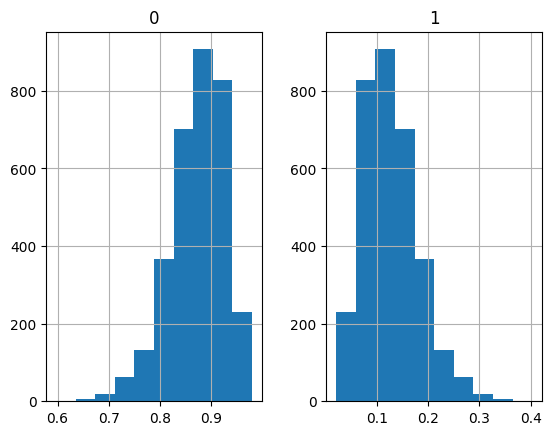

In [39]:
y_test = predictor.predict_proba(test_data, model=model_name)
perf = predictor.evaluate_predictions(
    y_true=test_data["y"], y_pred=y_test, auxiliary_metrics=True
)
y_test.hist(), perf

AUC Score: 0.6770225329316547


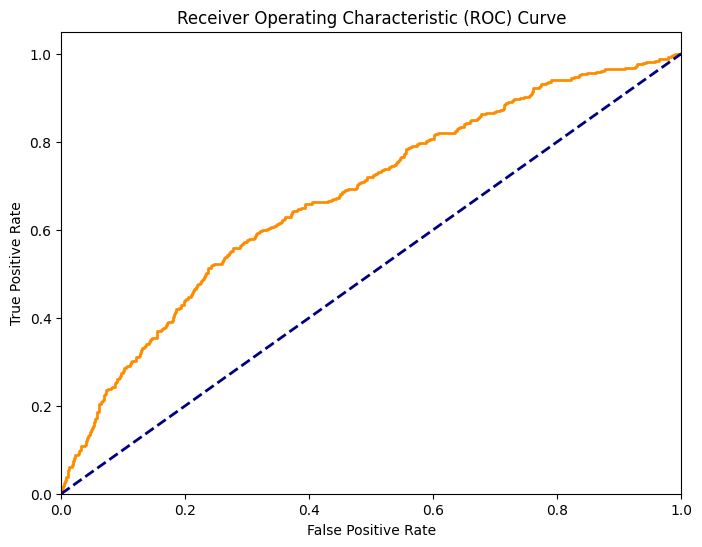

In [40]:
auc_score = roc_auc_score(test_data['y'], y_test[1])
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data['y'], y_test[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [42]:
pred = predictor.predict_proba(test, model=model_name)[1]
pred
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 52 features using 3252 rows with 5 shuffle sets...
	1070.73s	= Expected runtime (214.15s per shuffle set)
	514.72s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Leasing_enquiry_count,0.016467,0.002581,0.000070,5,0.021781,0.011153
Overdraft_balance,0.014929,0.004105,0.000622,5,0.023382,0.006477
employment_months,0.014095,0.004667,0.001253,5,0.023704,0.004486
number_of_children,0.010985,0.002250,0.000200,5,0.015618,0.006351
credit_score,0.010767,0.002523,0.000337,5,0.015961,0.005573
c_monthly_salary,0.004846,0.002449,0.005739,5,0.009889,-0.000198
r_generalcode3,0.004432,0.003391,0.021569,5,0.011413,-0.002550
Other_installment_purchase_balance,0.004238,0.000959,0.000294,5,0.006212,0.002264
c_number_of_employee,0.003843,0.001349,0.001557,5,0.006621,0.001066
c_occupation,0.003633,0.001975,0.007350,5,0.007700,-0.000434


# Submit

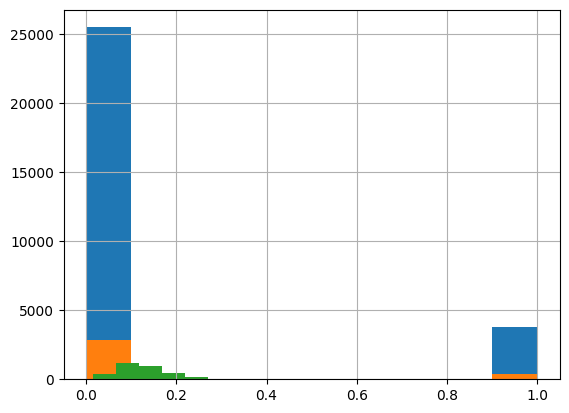

In [37]:
train_data['y'].hist(), test_data['y'].hist()
y_test[1].hist()
sub = pd.read_csv(data_root + 'submission_template_for_public.csv')
sub['default_12month'] = pred
sub

sub.to_csv(f'y_v8_{model_name}.csv', index=False)